/tmp/ipykernel_62162/2287024702.py:4: DtypeWarning: Columns (142,151,160,169,178,187,196,205,214,223,232,349,358,367,376,385,394,403,412,421,430,439,448,456,464,472,480,488,496,504,512,520,528,536,544,552,560,568,576,584,592,600,608,616,624,632,640,1101,1106,1180,1185,1572,1573,1575) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/home/umang23239/Chemi/IP_MT22209/Input Files/SMILES_CDK5/final_data_label.csv").drop_duplicates(subset='Canonical SMILES',keep='first').dropna(axis=0).reset_index(drop=True)


Index(['ABC', 'ABCGG', 'nAcid', 'nBase', 'SpAbs_A', 'SpMax_A', 'SpDiam_A',
       'SpAD_A', 'SpMAD_A', 'LogEE_A',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=1826)
Cross-Validation Metrics:
R²: 0.5774
RMSE: 0.7419
MSE: 0.5516
MAE: 0.5154

Test Metrics:
R²: 0.6588
RMSE: 0.6935
MSE: 0.4809
MAE: 0.4845


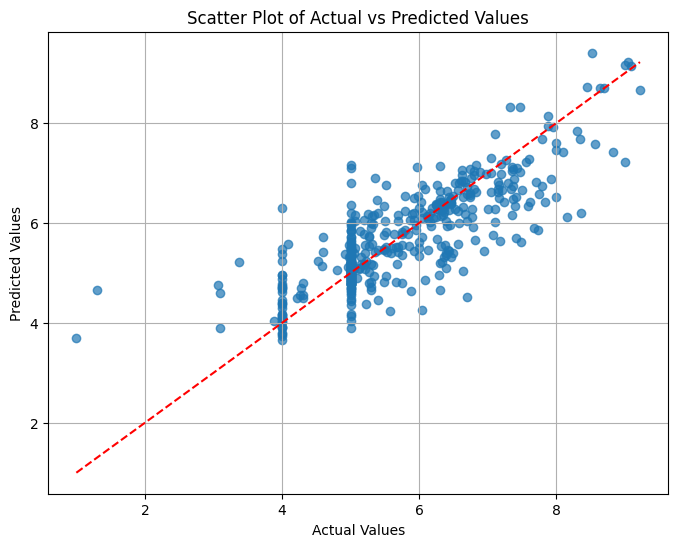

In [1]:

# %%
import pandas as pd

data=pd.read_csv("/home/umang23239/Chemi/MT23239/Input Files/SMILES_CDK5/final_data_label.csv").drop_duplicates(subset='Canonical SMILES',keep='first').dropna(axis=0).reset_index(drop=True)
data

# %%
X=data.iloc[:,:-7]
X

# %%
y=data['pIC50']
y

# %%
data_f=X

# %%
for column in data_f.columns:
    if data_f[column].dtype == object:
        data_f[column] = pd.to_numeric(data_f[column], errors='coerce').fillna(0)
    elif pd.api.types.is_numeric_dtype(data_f[column]):
        data_f[column] = pd.to_numeric(data_f[column], errors='coerce').fillna(0)
    else:
        data_f[column] = 0.0
data_f

# %%
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_f, y,test_size=.2,random_state =123)


# %%


# %%
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)

# %%
X_train_scaled_df=pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled_df


select_column=X_train_scaled_df.columns

# %%
print(select_column)

# %%
X_test_scaled_df=pd.DataFrame(X_test_scaled,columns=X_test.columns)
X_test_scaled_df

# # %%
# from lazypredict.Supervised import LazyRegressor

# import numpy as np

# reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None )
# models,predictions = reg.fit(X_train_scaled_df, X_test_scaled_df, y_train, y_test)
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# SVR model with the given parameters
svr_model = SVR(C=10, epsilon=0.1, kernel='rbf')

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation predictions
cv_predictions = cross_val_predict(svr_model, X_train_scaled_df, y_train, cv=kf)

# Cross-validation scores
cv_r2 = cross_val_score(svr_model, X_train_scaled_df, y_train, cv=kf, scoring='r2')
cv_mse = cross_val_score(svr_model, X_train_scaled_df, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mae = cross_val_score(svr_model, X_train_scaled_df, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Calculate RMSE from MSE
cv_rmse = np.sqrt(-cv_mse)

# Print cross-validation metrics
print("Cross-Validation Metrics:")
print(f"R²: {np.mean(cv_r2):.4f}")
print(f"RMSE: {np.mean(cv_rmse):.4f}")
print(f"MSE: {np.mean(-cv_mse):.4f}")
print(f"MAE: {np.mean(-cv_mae):.4f}")

# Train the model on the full training data
svr_model.fit(X_train_scaled_df, y_train)

# Predictions on test data
y_test_pred = svr_model.predict(X_test_scaled_df)

# Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nTest Metrics:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Actual vs Predicted Values")
plt.grid(True)
plt.savefig("/home/umang23239/Chemi/MT23239/Input Files/SMILES_CDK5/scatter.jpeg")
# plt.show()

import pickle

model_param={
    
    'select_colum':select_column,
    'model':svr_model,
    'scaler':sc
}

with open("/home/umang23239/Chemi/MT23239/Input Files/SMILES_CDK5/model_svr.pkl",'wb') as file:
    pickle.dump(model_param,file)